In [2]:
import os
import sys
sys.path.append(os.getcwd() + '/module')
print(os.getcwd())
from module import *
from math import pi
PI = pi
del pi

/home/usrainz/PycharmProjects/JupyterProject


In [4]:
####
# Build Simulation
####

# Create Simulation Object
# with configuration from path
sim = Simulation(f'experiments/prove_of_concept.npy')

# Define linear path
filter_s1 = sim.lti.system[sim.cfg.filter1_type](
    sr=sim.cfg.samplerate,
    wc=sim.cfg.filter1_fc*2*PI,
    q=sim.cfg.filter1_q,
    is_callable=True)

# Define x²-path
filter_s21 = sim.lti.system[sim.cfg.filter21_type](
    sr=sim.cfg.samplerate,
    wc=sim.cfg.filter21_fc*2*PI,
    q=sim.cfg.filter1_q,
    delay=sim.cfg.delay,
    is_callable=True)

filter_s22 = sim.lti.system[sim.cfg.filter22_type](
    sr=sim.cfg.samplerate,
    wc=sim.cfg.filter22_fc*2*PI,
    q=sim.cfg.filter22_q,
    gain=sim.cfg.filter22_gain,
    delay=sim.cfg.delay,
    is_callable=True)

# Define x³-path
filter_s31 = sim.lti.system[sim.cfg.filter31_type](
    sr=sim.cfg.samplerate,
    wc=sim.cfg.filter31_fc*2*PI,
    q=sim.cfg.filter31_q,
    delay=sim.cfg.delay,
    is_callable=True)

filter_s32 = sim.lti.system[sim.cfg.filter32_type](
    sr=sim.cfg.samplerate,
    wc=sim.cfg.filter32_fc*2*PI,
    q=sim.cfg.filter32_q,
    delay=sim.cfg.delay,
    is_callable=True)

# Construct parallel paths of SM-System
sm1 = SM_System(pre=filter_s1,  nl=lambda x: x,    post=filter_s1,  name='sm1')
sm2 = SM_System(pre=filter_s21, nl=lambda x: x**2, post=filter_s22, name='sm2')
sm3 = SM_System(pre=filter_s31, nl=lambda x: x**3, post=filter_s32, name='sm3')

# Initialize SM-System of order 3
sim.set_sm(sm:= sm1 + sm2 + sm3)

# Help the garbage collector
del sm1, sm2, sm3

60it [00:00, 326.10it/s]
60it [00:00, 297.04it/s]
60it [00:00, 354.45it/s]
60it [00:00, 326.34it/s]
60it [00:00, 346.26it/s]
60it [00:00, 379.44it/s]
60it [00:00, 305.26it/s]
60it [00:00, 342.61it/s]


In [5]:
####
# Harmonic Probes
####

sim.build_harmonic_probes()    
freq_pairs = sim.harmonic_probes.freq_pairs
config = sim.cfg
probes = sim.harmonic_probes()

60it [00:00, 340.75it/s]
60it [00:00, 340.74it/s]
60it [00:00, 323.93it/s]
60it [00:00, 343.57it/s]
60it [00:00, 387.31it/s]
60it [00:00, 380.92it/s]
60it [00:00, 341.54it/s]
60it [00:00, 329.75it/s]


In [6]:
####
# Run Simulation
####

LOAD = False

if LOAD:
    simulated_signals = np.load('simulated_signals.npy')
else:
    simulated_signals = sim.run()
    np.save('simulated_signals', simulated_signals)
    print('Done!')

simulated_signals_clean = simulated_signals

60it [00:10,  5.69it/s]
60it [00:10,  5.88it/s]
60it [00:13,  4.35it/s]
60it [00:11,  5.08it/s]
60it [00:11,  5.23it/s]
60it [00:10,  5.68it/s]
60it [00:11,  5.12it/s]
60it [00:10,  5.48it/s]

Done!


In [8]:
####
# Add noise
# scale = standard deviation
####

add_noise = False
SNR_db = 20

if add_noise:
    signal_power_level_db = 20*np.log10(rms(simulated_signals_clean))
    noise = noise_like(simulated_signals, signal_power_level_db - SNR_db)
    simulated_signals = simulated_signals_clean + noise
    print(snr_db(simulated_signals, noise))

else:
    'define SNR_db for proper plot-identification'
    SNR_db = 'no noise'
    simulated_signals = simulated_signals_clean

In [9]:
####
# Linear System
####

indices = calc_signed_indices(freq_pairs, config.probes_fft_delta)

levels = extract_levels(signals=simulated_signals)
fft = np.fft.rfft(simulated_signals)
phases = np.angle(fft, deg=True)

####
# x^2-path
####
coef_matrix_x2,  x_idx_pre_x2, x_idx_post_x2 = build_coef_matrix_order2(indices)
print('Jakobi-Matrix (x^2) has fullrank: ',  check_full_rank(coef_matrix_x2))

freq_pre_x2 = x_idx_pre_x2 * sim.cfg.probes_fft_delta
freq_post_x2 = x_idx_post_x2 * sim.cfg.probes_fft_delta

lhs_lvl_x2, lhs_phase_x2, idx_x2 = clc_lhs_order_2(levels, phases, indices)


####
# x^3-path
####
coef_matrix_x3,  x_idx_pre_x3, x_idx_post_x3 = build_coef_matrix_order3(indices)
print('Jakobi-Matrix (x^3) has fullrank: ',  check_full_rank(coef_matrix_x3))

freq_pre_x3 = x_idx_pre_x3 * sim.cfg.probes_fft_delta
freq_post_x3 = x_idx_post_x3 * sim.cfg.probes_fft_delta

lhs_lvl_x3, lhs_phase_x3, idx_x3 = clc_lhs_order_3(levels, phases, indices)


####
# Dead-time to zero
####
tz_x3, tz_x2 = 0, 0


Jakobi-Matrix (x^2) has fullrank:  False
Jakobi-Matrix (x^3) has fullrank:  False


In [11]:
####
# Identification
# Magnitude of SM21 and SM22
###

OPTION = sim.cfg.constraint_amp_s2

lhs = lhs_lvl_x2
first_post_idx_x2 = freq_pairs.shape[1] # sim.cfg.probes_n

if OPTION == 'ONE':
    # First-Pre == 0 !
    # eg: Pre = Low-Pass
    coef_matrix_mag_x2 =  ensure_fullrank(coef_matrix_x2, 0)
    freq_pre_mag_x2 = freq_pre_x2[1:]
    freq_post_mag_x2 = freq_post_x2
    
if OPTION == 'TWO':
    # Last-Post == 0 !
    # eg: Post = High-Pass
    coef_matrix_mag_x2 =  ensure_fullrank(coef_matrix_x2, -1)
    freq_pre_mag_x2 = freq_pre_x2
    freq_post_mag_x2 = freq_post_x2[:-1]

if OPTION == 'THREE':
    # First-Post == 0 !
    # eg: Post = Low-Pass
    coef_matrix_mag_x2 =  ensure_fullrank(coef_matrix_x2, first_post_idx_x2)
    freq_pre_mag_x2 = freq_pre_x2
    freq_post_mag_x2 = freq_post_x2[1:]
    
if OPTION == 'FOUR':
    # Last-Pre == 0 !
    # eg: Pre = High-Pass
    coef_matrix_mag_x2 =  ensure_fullrank(coef_matrix_x2, first_post_idx_x2-1)
    freq_pre_mag_x2 = freq_pre_x2[:-1]
    freq_post_mag_x2 = freq_post_x2  
    

coef_matrix_pinv_mags_x2 = np.linalg.pinv(np.abs(coef_matrix_mag_x2))
lms_mags_x2 = np.einsum('uv, ...v -> ...u', coef_matrix_pinv_mags_x2, lhs.reshape((-1)))


####
# Magnitude of SM31 and SM32
###

OPTION = sim.cfg.constraint_amp_s3

lhs = lhs_lvl_x3
first_post_idx_x3 = freq_pairs.shape[1] # sim.cfg.probes_n

if OPTION == 'ONE':
    # First-Pre == 0 !
    # eg: Pre = Low-Pass
    coef_matrix_mag_x3 =  ensure_fullrank(coef_matrix_x3, 0)
    freq_pre_mag_x3 = freq_pre_x3[1:]
    freq_post_mag_x3 = freq_post_x3 
    

if OPTION == 'TWO':
    # Last-Post == 0 !
    # eg: Post = High-Pass
    coef_matrix_mag_x3 =  ensure_fullrank(coef_matrix_x3, -1)
    freq_pre_mag_x3 = freq_pre_x3
    freq_post_mag_x3 = freq_post_x3[:-1] #

if OPTION == 'THREE':
    # First-Post == 0 !
    # eg: Post = Low-Pass
    coef_matrix_mag_x3 =  ensure_fullrank(coef_matrix_x3, first_post_idx_x3)
    freq_pre_mag_x3 = freq_pre_x3
    freq_post_mag_x3 = freq_post_x3[1:]
    
if OPTION == 'FOUR':
    # Last-Pre == 0 !
    # eg: Pre = High-Pass
    coef_matrix_mag_x3 =  ensure_fullrank(coef_matrix_x3, first_post_idx_x3-1)
    freq_pre_mag_x3 = freq_pre_x3[:-1]
    freq_post_mag_x3 = freq_post_x3    


coef_matrix_pinv_mags_x3 = np.linalg.pinv(np.abs(coef_matrix_mag_x3))
lms_mags_x3 = np.einsum('uv, ...v -> ...u', coef_matrix_pinv_mags_x3, lhs.reshape((-1)))



Jakobi-matrix has full rank!
Jakobi-matrix has full rank!


In [12]:
####
# Reset Phase
####

p_x2 = lhs_phase_x2
p_x3 = lhs_phase_x3

In [13]:
####
# Identification
# Phase of SM21 and SM22
###

OPTION = sim.cfg.constraint_phase_s2

lhs_phase_x2 = p_x2
lhs_phase_x2 = lhs_phase_x2.reshape((-1)) 
coef_matrix_phase_x2 = coef_matrix_x2
freq_pre_phase_x2 = freq_pre_x2
freq_post_phase_x2 = freq_post_x2

if OPTION == 'NONE':
    pass

elif OPTION == 'ONE':

    # empirical Pre-Filter deadtime := 0

    delay = 0
    lhs_phase_x2 = np.hstack([lhs_phase_x2, delay])
    dead_time_parameters = (-1 / (freq_pre_phase_x2*360 * freq_pre_phase_x2.size))
    dead_time_parameters = np.hstack([dead_time_parameters, freq_post_phase_x2*0])
    dead_time_parameters = dead_time_parameters.reshape((1, -1))
    coef_matrix_phase_x2 = np.vstack([coef_matrix_phase_x2, dead_time_parameters])

    
elif OPTION == 'Two':

    # empirical Post-Filter deadtime := 0

    delay = 0
    lhs_phase_x2 = np.hstack([lhs_phase_x2, delay])
    dead_time_parameters = (-1 / (freq_post_phase_x2*360 * freq_post_phase_x2.size))
    dead_time_parameters = np.hstack([freq_pre_phase_x2*0, dead_time_parameters])
    dead_time_parameters = dead_time_parameters.reshape((1, -1))
    coef_matrix_phase_x2 = np.vstack([coef_matrix_phase_x2, dead_time_parameters]) 

else:
    print('wrong OPTION!!!')
    

if not check_full_rank(coef_matrix_phase_x2):
    print('WARNING: Jakobi-matrix - NOT full rank!')

coef_matrix_pinv_phase_x2 = np.linalg.pinv(coef_matrix_phase_x2)

lms_phase_x2 = np.einsum('uv, ...v -> ...u', coef_matrix_pinv_phase_x2, lhs_phase_x2)


In [14]:
####
# Identification
# Phase of SM31 and SM32
###

# Pre - Lowpass & Post - Highpass:
OPTION = sim.cfg.constraint_phase_s3

lhs_phase_x3 = p_x3 #np.mod(p, 360) # p
lhs_phase_x3 = lhs_phase_x3.reshape((-1)) 
coef_matrix_phase_x3 = coef_matrix_x3
freq_pre_phase_x3 = freq_pre_x3
freq_post_phase_x3 = freq_post_x3

if OPTION == 'NONE':
    pass
    

elif OPTION == 'ONE':

    # empirical Pre-Filter deadtime := 0

    delay = 0

    lhs_phase_x3 = np.hstack([lhs_phase_x3, delay])
    dead_time_parameters = (-1 / (freq_pre_phase_x3*360 * freq_pre_phase_x3.size))
    dead_time_parameters = np.hstack([dead_time_parameters, freq_post_phase_x3*0])
    dead_time_parameters = dead_time_parameters.reshape((1, -1))
    coef_matrix_phase_x3 = np.vstack([coef_matrix_phase_x3, dead_time_parameters])

    
elif OPTION == 'TWO':

    # empirical Post-Filter deadtime := 0

    delay = 0
    
    lhs_phase_x3 = np.hstack([lhs_phase_x3, delay])
    dead_time_parameters = (-1 / (freq_post_phase_x3*360 * freq_post_phase_x3.size))
    dead_time_parameters = np.hstack([freq_pre_phase_x3*0, dead_time_parameters])
    dead_time_parameters = dead_time_parameters.reshape((1, -1))
    coef_matrix_phase_x3 = np.vstack([coef_matrix_phase_x3, dead_time_parameters]) 
    

else:
    print('wrong OPTION!!!')
    

if not check_full_rank(coef_matrix_phase_x2):
    print('WARNING: Jakobi-matrix - NOT full rank!')


coef_matrix_pinv_phase_x3 = np.linalg.pinv(coef_matrix_phase_x3)

lms_phase_x3 = np.einsum('uv, ...v -> ...u', coef_matrix_pinv_phase_x3, lhs_phase_x3)

In [15]:
def calc_offset(system, freq_mag, freq_phase, mag, phase):
    _, mag_last, phase_last = scipy.signal.bode(system, [2*np.pi*freq_mag, 2*np.pi*freq_phase])   
    return mag_last[0]-mag, (phase_last[1]-phase)/freq_phase

In [14]:
sim.cfg.path

'experiments/prove_of_concept/'

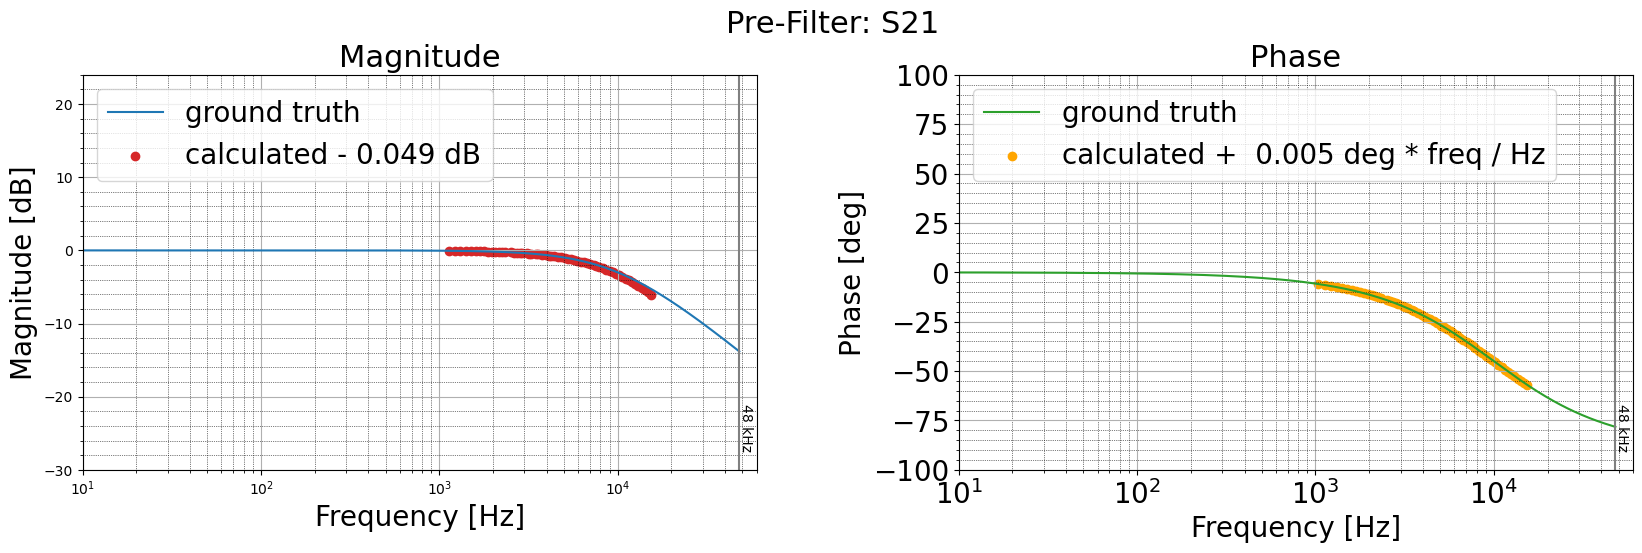

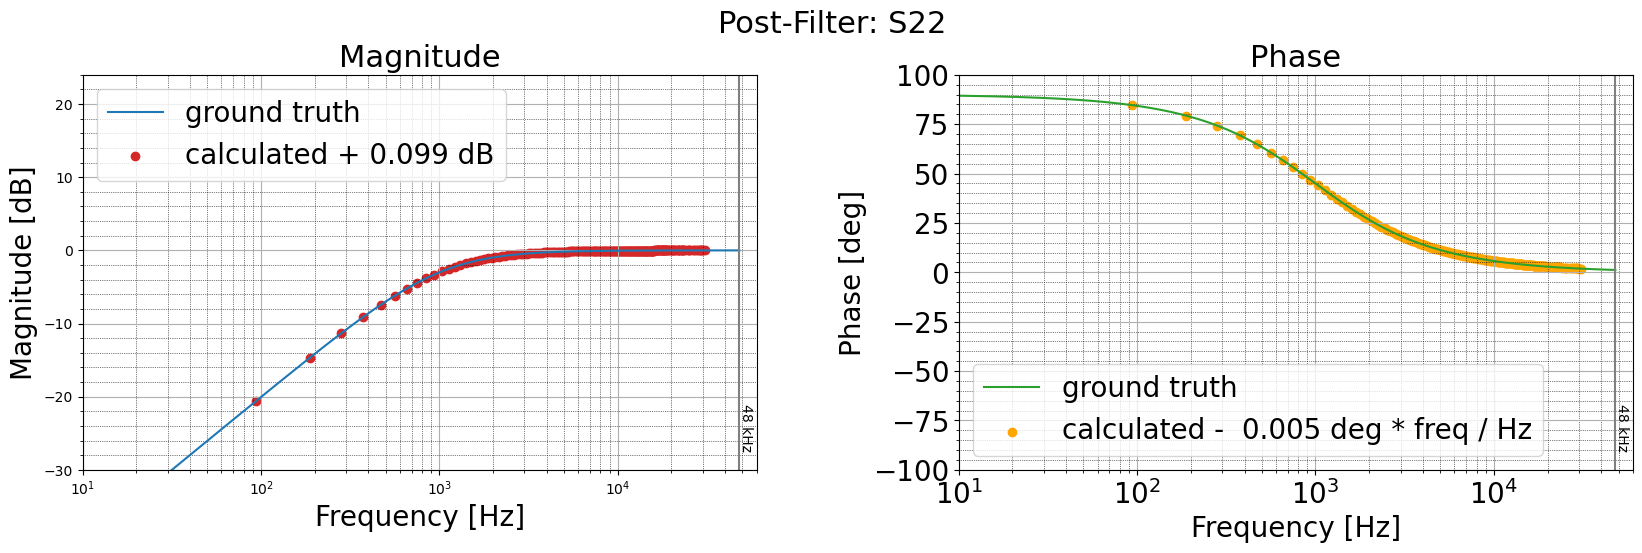

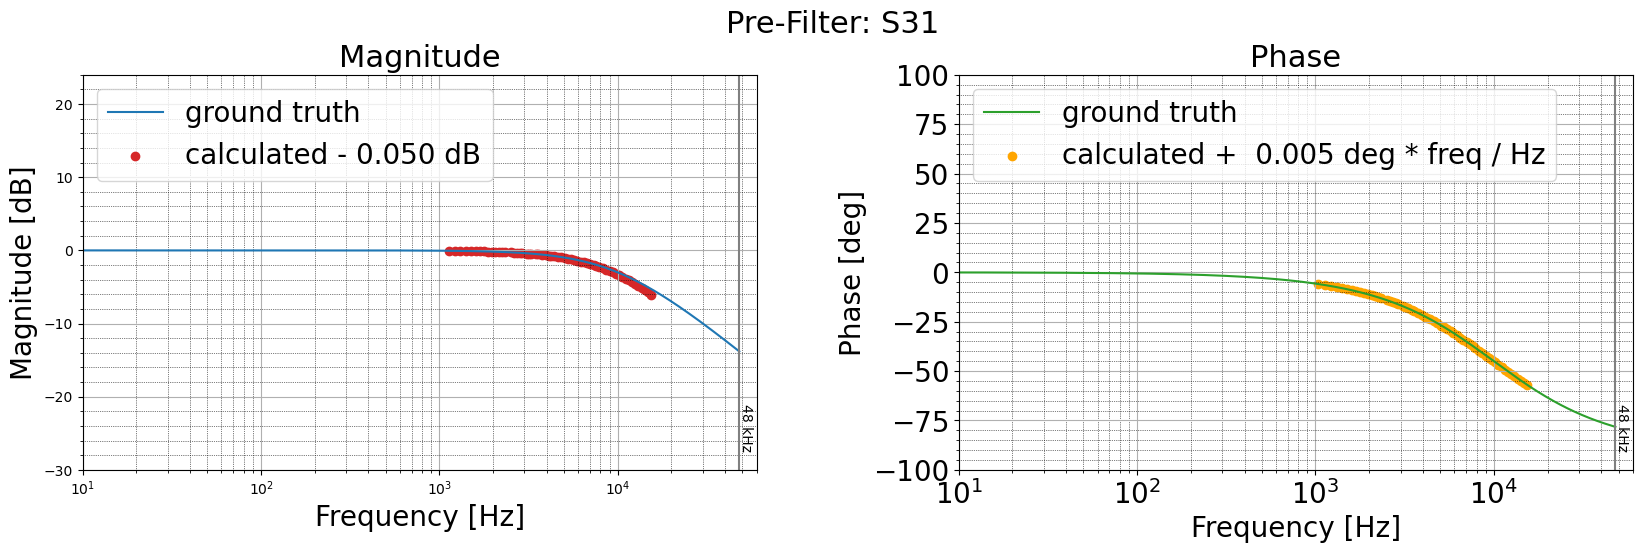

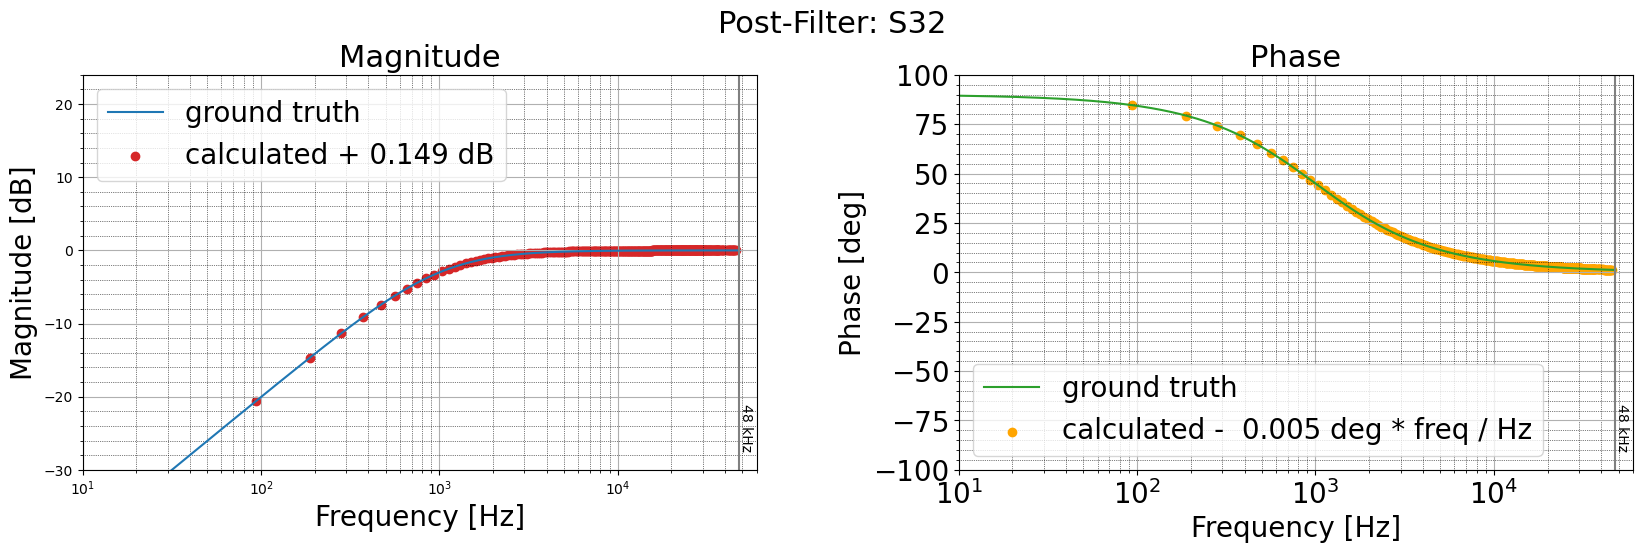

In [16]:
####
# Plot Results
####

nyquist = int(sim.cfg.samplerate / 2)

save = True
save_individual = True

path2results = sim.cfg.path

if not os.path.exists(path2results):
    os.makedirs(path2results)

limits = [[-30, 24], [-100, 100]]
legend_locations = ['best', 'best', 'best', 'best']

# Pre-Filter: S21
system_s21 = sim.lti.system[sim.cfg.filter21_type](sr=sim.cfg.samplerate, wc=2*PI*sim.cfg.filter21_fc, q=sim.cfg.filter21_q, lag=sim.cfg.filter21_lag)

# calc offset
system_s22 = sim.lti.system[sim.cfg.filter22_type](sr=sim.cfg.samplerate, wc=2*PI*sim.cfg.filter22_fc, q=sim.cfg.filter22_q, lag=sim.cfg.filter22_lag)
mag_offset_x2, tz_x2 = calc_offset(system_s22,
                                freq_post_mag_x2[-1],
                                freq_post_phase_x2[-1], 
                                lms_mags_x2[freq_pre_mag_x2.size:][-1],
                                lms_phase_x2[freq_pre_phase_x2.size:][-1])

mag_offset_x2, tz_x2 = mag_offset_x2, -tz_x2

w = 2*PI*np.arange(1, nyquist-1, 1)
w, mag, phase = scipy.signal.bode(system_s21, w)
f = w/(2*PI)
fig, ax = plot_bode_measurement(
    freq_gt=f,
    mag_gt=mag,
    phase_gt=phase,
    sampling_rate=sim.cfg.samplerate,
    plot_labels = [['ground truth', f'calculated -{np.abs(0.5*mag_offset_x2): .3f} dB'], ['ground truth', f'calculated + {np.abs(tz_x2): .3f} deg * freq / Hz']],
    freq_mag=freq_pre_mag_x2,
    mag=lms_mags_x2[:freq_pre_mag_x2.size] - 0.5*mag_offset_x2,#-4.77,
    freq_phase=freq_pre_phase_x2,
    phase=lms_phase_x2[:freq_pre_phase_x2.size] + freq_pre_phase_x2 * tz_x2,
    limits = limits,
    plot_title='Pre-Filter: S21',
    legend_location=legend_locations[0],
    save=save,
    save_individual=save_individual,
    path = path2results + str(SNR_db) + ' ',
)

# Post-Filter: S22
system_s22 = sim.lti.system[sim.cfg.filter22_type](sr=sim.cfg.samplerate, wc=2*PI*sim.cfg.filter22_fc, q=sim.cfg.filter22_q, lag=sim.cfg.filter22_lag, zeros=sim.cfg.filter22_zeros, poles=sim.cfg.filter22_poles)

w = 2*PI*np.arange(1, nyquist-1, 1)
w, mag, phase = scipy.signal.bode(system_s22, w)
f = w/(2*PI)
fig, ax = plot_bode_measurement(
    freq_gt=f,
    mag_gt=mag,
    phase_gt=phase,
    sampling_rate=sim.cfg.samplerate,
    plot_labels = [['ground truth', f'calculated +{np.abs(mag_offset_x2): .3f} dB'], ['ground truth', f'calculated - {np.abs(tz_x2): .3f} deg * freq / Hz']],
    freq_mag=freq_post_mag_x2,
    mag=lms_mags_x2[freq_pre_mag_x2.size:] + mag_offset_x2,
    freq_phase=freq_post_phase_x2,
    phase=lms_phase_x2[freq_pre_phase_x2.size:] - freq_post_phase_x2 * tz_x2,
    limits = limits,
    plot_title='Post-Filter: S22',
    legend_location=legend_locations[1],
    save=save,
    save_individual=save_individual,
    path = path2results + str(SNR_db) + ' ',
)

# Pre-Filter: S31
system_s31 = sim.lti.system[sim.cfg.filter31_type](sr=sim.cfg.samplerate, wc=2*PI*sim.cfg.filter31_fc, q=sim.cfg.filter31_q, lag=sim.cfg.filter31_lag)

# calc offset
system_s32 = sim.lti.system[sim.cfg.filter32_type](sr=sim.cfg.samplerate, wc=2*PI*sim.cfg.filter32_fc, q=sim.cfg.filter32_q, lag=sim.cfg.filter32_lag)
mag_offset_x3, tz_x3 = calc_offset(system_s32,
                                freq_post_mag_x3[-1],
                                freq_post_phase_x3[-1], 
                                lms_mags_x3[freq_pre_mag_x3.size:][-1],
                                lms_phase_x3[freq_pre_phase_x3.size:][-1])
mag_offset_x3, tz_x3 = mag_offset_x3, -tz_x3

w = 2*PI*np.arange(1, nyquist-1, 1)
w, mag, phase = scipy.signal.bode(system_s31, w)
f = w/(2*PI)
fig, ax = plot_bode_measurement(
    freq_gt=f,
    mag_gt=mag,
    phase_gt=phase,
    sampling_rate=sim.cfg.samplerate,
    plot_labels = [['ground truth', f'calculated -{np.abs(mag_offset_x3/3): .3f} dB'], ['ground truth', f'calculated + {np.abs(tz_x3): .3f} deg * freq / Hz']],
    freq_mag=freq_pre_mag_x3,
    mag=lms_mags_x3[:freq_pre_mag_x3.size] - mag_offset_x3/3,
    freq_phase=freq_pre_phase_x3,
    phase=lms_phase_x3[:freq_pre_phase_x3.size] + freq_pre_phase_x3 * tz_x3,
    limits = limits,
    plot_title='Pre-Filter: S31',
    legend_location=legend_locations[2],
    save=save,
    save_individual=save_individual,
    path = path2results + str(SNR_db) + ' ',
)

# Post-Filter: S32
system_s32 = sim.lti.system[sim.cfg.filter32_type](sr=sim.cfg.samplerate, wc=2*PI*sim.cfg.filter32_fc, q=sim.cfg.filter32_q, lag=sim.cfg.filter32_lag)
w = 2*PI*np.arange(1, nyquist-1, 1)
w, mag, phase = scipy.signal.bode(system_s32, w)
f = w/(2*PI)
fig, ax = plot_bode_measurement(
    freq_gt=f,
    mag_gt=mag,
    phase_gt=phase,
    sampling_rate=sim.cfg.samplerate,
    plot_labels = [['ground truth', f'calculated +{np.abs(mag_offset_x3): .3f} dB'], ['ground truth', f'calculated - {np.abs(tz_x3): .3f} deg * freq / Hz']],
    freq_mag=freq_post_mag_x3,
    mag=lms_mags_x3[freq_pre_mag_x3.size:] + mag_offset_x3,
    freq_phase=freq_post_phase_x3,
    phase=lms_phase_x3[freq_pre_phase_x3.size:] - freq_post_phase_x3 * tz_x3,
    limits = limits,
    plot_title='Post-Filter: S32',
    legend_location=legend_locations[3],
    save=save,
    save_individual=save_individual,
    path = path2results + str(SNR_db) + ' ',
)
